In [55]:
from __future__ import print_function, division
import sys
import os
import torch
import numpy as np
import random
import csv
from typing import List, Tuple
from torch.utils.data import Dataset, DataLoader
import math
import torch
import torch.nn as nn
import torch.utils.data
from visualDet3D.utils.utils import alpha2theta_3d, theta2alpha_3d
from visualDet3D.data.kitti.kittidata import KittiData, KittiObj, KittiCalib
from visualDet3D.data.pipeline import build_augmentator
import os
import pickle
import numpy as np
from copy import deepcopy
from visualDet3D.networks.utils import BBox3dProjector
from visualDet3D.networks.utils.registry import DATASET_DICT
import sys
from matplotlib import pyplot as plt
from collections import namedtuple
from numpy.linalg import inv

ros_py_path = '/opt/ros/kinetic/lib/python2.7/dist-packages'
if sys.version_info > (3, 0) and ros_py_path in sys.path:
    #Python 3, compatible with a naive ros environment
    sys.path.remove(ros_py_path)
    import cv2
    sys.path.append(ros_py_path)
else:
    #Python 2
    import cv2

Obj_3d = namedtuple('Obj_3d', ('cx', 'cy', 'z', 'w', 'h', 'l', 'alpha'))


In [56]:
def compute_3Dbox(P2, obj): # This is copy from mltoolkit/3d_object_detection_visualization/viz3Dbox.py
    # Project (cx, cy, z) to (x_3d, y_3d, z_3d), TODO, this is a problem when uses right image
    tx, ty, tz = inv(P2[:, :3]) @ np.array([obj.cx*obj.z, obj.cy*obj.z, obj.z])

    # Convert alpha to rot_y
    theta = math.atan2(tz, tx)
    # rot_y = obj.alpha + theta
    rot_y = obj.alpha - theta + math.pi/2.0
    
    # Draw 3D Bounding Box
    R = np.array([[ np.cos(rot_y), 0, np.sin(rot_y)],
                  [ 0            , 1, 0            ],
                  [-np.sin(rot_y), 0, np.cos(rot_y)]])
    
    x_corners = [0, obj.l, obj.l, obj.l, obj.l, 0,     0,     0]  # -l/2
    y_corners = [0, 0,     obj.h, obj.h, 0,     0,     obj.h, obj.h]  # -h
    z_corners = [0, 0,     0,     obj.w, obj.w, obj.w, obj.w, 0]  # -w/2

    x_corners = [i - obj.l / 2 for i in x_corners]
    y_corners = [i - obj.h / 2 for i in y_corners]
    z_corners = [i - obj.w / 2 for i in z_corners]

    corners_3D = np.array([x_corners, y_corners, z_corners])
    corners_3D = R.dot(corners_3D)
    corners_3D += np.array([tx, ty, tz]).reshape((3, 1))

    corners_3D_1 = np.vstack((corners_3D, np.ones((corners_3D.shape[-1]))))
    corners_2D = P2.dot(corners_3D_1)
    corners_2D = corners_2D / corners_2D[2]
    corners_2D = corners_2D[:2]
    
    return corners_2D


# @DATASET_DICT.register_module
class KittiMonoDataset(torch.utils.data.Dataset):
    """Some Information about KittiDataset"""
    def __init__(self, cfg, split='training'):
        super(KittiMonoDataset, self).__init__()
        preprocessed_path   = cfg.path.preprocessed_path
        obj_types           = cfg.obj_types
        is_train = (split == 'training')

        imdb_file_path = os.path.join(preprocessed_path, split, 'imdb.pkl')
        self.imdb = pickle.load(open(imdb_file_path, 'rb')) # list of kittiData
        self.output_dict = {
                "calib": False,
                "image": True,
                "label": False,
                "velodyne": False
            }
        if is_train:
            self.transform = build_augmentator(cfg.data.train_augmentation)
        else:
            self.transform = build_augmentator(cfg.data.test_augmentation)
        self.projector = BBox3dProjector()
        self.is_train = is_train
        self.obj_types = obj_types
        self.use_right_image = getattr(cfg.data, 'use_right_image', True)
        self.is_reproject = getattr(cfg.data, 'is_reproject', True) # if reproject 2d

    def _reproject(self, P2:np.ndarray, transformed_label:List[KittiObj]) -> Tuple[List[KittiObj], np.ndarray]:
        bbox3d_state = np.zeros([len(transformed_label), 7]) #[camera_x, camera_y, z, w, h, l, alpha]
        for obj in transformed_label:
            obj.alpha = theta2alpha_3d(obj.ry, obj.x, obj.z, P2)
        bbox3d_origin = torch.tensor([[obj.x, obj.y - 0.5 * obj.h, obj.z, obj.w, obj.h, obj.l, obj.alpha] for obj in transformed_label], dtype=torch.float32)
        abs_corner, homo_corner, _ = self.projector(bbox3d_origin, bbox3d_origin.new(P2))
        for i, obj in enumerate(transformed_label):
            extended_center = np.array([obj.x, obj.y - 0.5 * obj.h, obj.z, 1])[:, np.newaxis] #[4, 1]
            extended_bottom = np.array([obj.x, obj.y, obj.z, 1])[:, np.newaxis] #[4, 1]
            image_center = (P2 @ extended_center)[:, 0] #[3]
            image_center[0:2] /= image_center[2]

            image_bottom = (P2 @ extended_bottom)[:, 0] #[3]
            image_bottom[0:2] /= image_bottom[2]
            
            bbox3d_state[i] = np.concatenate([image_center,
                                                [obj.w, obj.h, obj.l, obj.alpha]]) #[7]

        max_xy, _= homo_corner[:, :, 0:2].max(dim = 1)  # [N,2]
        min_xy, _= homo_corner[:, :, 0:2].min(dim = 1)  # [N,2]

        result = torch.cat([min_xy, max_xy], dim=-1) #[:, 4]

        bbox2d = result.cpu().numpy()

        if self.is_reproject:
            for i in range(len(transformed_label)):
                transformed_label[i].bbox_l = bbox2d[i, 0]
                transformed_label[i].bbox_t = bbox2d[i, 1]
                transformed_label[i].bbox_r = bbox2d[i, 2]
                transformed_label[i].bbox_b = bbox2d[i, 3]
        
        return transformed_label, bbox3d_state


    def __getitem__(self, index):
        kitti_data = self.imdb[index % len(self.imdb)]
        # The calib and label has been preloaded to minimize the time in each indexing
        if index >= len(self.imdb):
            kitti_data.output_dict = {
                "calib": True,
                "image": False,
                "image_3":True,
                "label": False,
                "velodyne": False
            }
            calib, _, image, _, _ = kitti_data.read_data()
            calib.P2 = calib.P3 # a workaround to use P3 for right camera images. 3D bboxes are the same(cx, cy, z, w, h, l, alpha)
        else:
            kitti_data.output_dict = self.output_dict
            _, image, _, _ = kitti_data.read_data()
            calib = kitti_data.calib
        calib.image_shape = image.shape
        label = kitti_data.label # label: list of kittiObj
        label = []
        for obj in kitti_data.label:
            if obj.type in self.obj_types:
                label.append(obj)
        transformed_image, transformed_P2, transformed_label = self.transform(image, p2=deepcopy(calib.P2), labels=deepcopy(label))
        bbox3d_state = np.zeros([len(transformed_label), 7]) #[camera_x, camera_y, z, w, h, l, alpha]
        if len(transformed_label) > 0:
            transformed_label, bbox3d_state = self._reproject(transformed_P2, transformed_label)

        bbox2d = np.array([[obj.bbox_l, obj.bbox_t, obj.bbox_r, obj.bbox_b] for obj in transformed_label])
        
        output_dict = {'calib': transformed_P2,
                       'image': transformed_image,
                       'label': [obj.type for obj in transformed_label], 
                       'bbox2d': bbox2d, #[N, 4] [x1, y1, x2, y2]
                       'bbox3d': bbox3d_state, 
                       'original_shape':image.shape,
                       'original_P':calib.P2.copy()}
        return output_dict

    def __len__(self):
        if self.is_train and self.use_right_image:
            return len(self.imdb) * 2
        else:
            return len(self.imdb)

    @staticmethod
    def collate_fn(batch):
        rgb_images = np.array([item["image"] for item in batch])#[batch, H, W, 3]
        rgb_images = rgb_images.transpose([0, 3, 1, 2])

        calib = [item["calib"] for item in batch]
        label = [item['label'] for item in batch]
        bbox2ds = [item['bbox2d'] for item in batch]
        bbox3ds = [item['bbox3d'] for item in batch]
        # This line will cause warning: 
        # Creating a tensor from a list of numpy.ndarrays is extremely slow. 
        # Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.
        # add np.array() to avoid warning.
        return torch.from_numpy(rgb_images).float(), torch.tensor(np.array(calib)).float(), label, bbox2ds, bbox3ds


calib.P2 = [[7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01]
 [0.000000e+00 7.215377e+02 1.728540e+02 2.163791e-01]
 [0.000000e+00 0.000000e+00 1.000000e+00 2.745884e-03]]
calib.P2 = [[7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01]
 [0.000000e+00 7.215377e+02 1.728540e+02 2.163791e-01]
 [0.000000e+00 0.000000e+00 1.000000e+00 2.745884e-03]]
calib.P2 = [[7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01]
 [0.000000e+00 7.215377e+02 1.728540e+02 2.163791e-01]
 [0.000000e+00 0.000000e+00 1.000000e+00 2.745884e-03]]
calib.P2 = [[7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01]
 [0.000000e+00 7.215377e+02 1.728540e+02 2.163791e-01]
 [0.000000e+00 0.000000e+00 1.000000e+00 2.745884e-03]]
calib.P2 = [[7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01]
 [0.000000e+00 7.215377e+02 1.728540e+02 2.163791e-01]
 [0.000000e+00 0.000000e+00 1.000000e+00 2.745884e-03]]
calib.P3 = [[ 7.215377e+02  0.000000e+00  6.095593e+02 -3.395242e+02]
 [ 0.000000e+00  7.215377e+02  1.728540e+02  

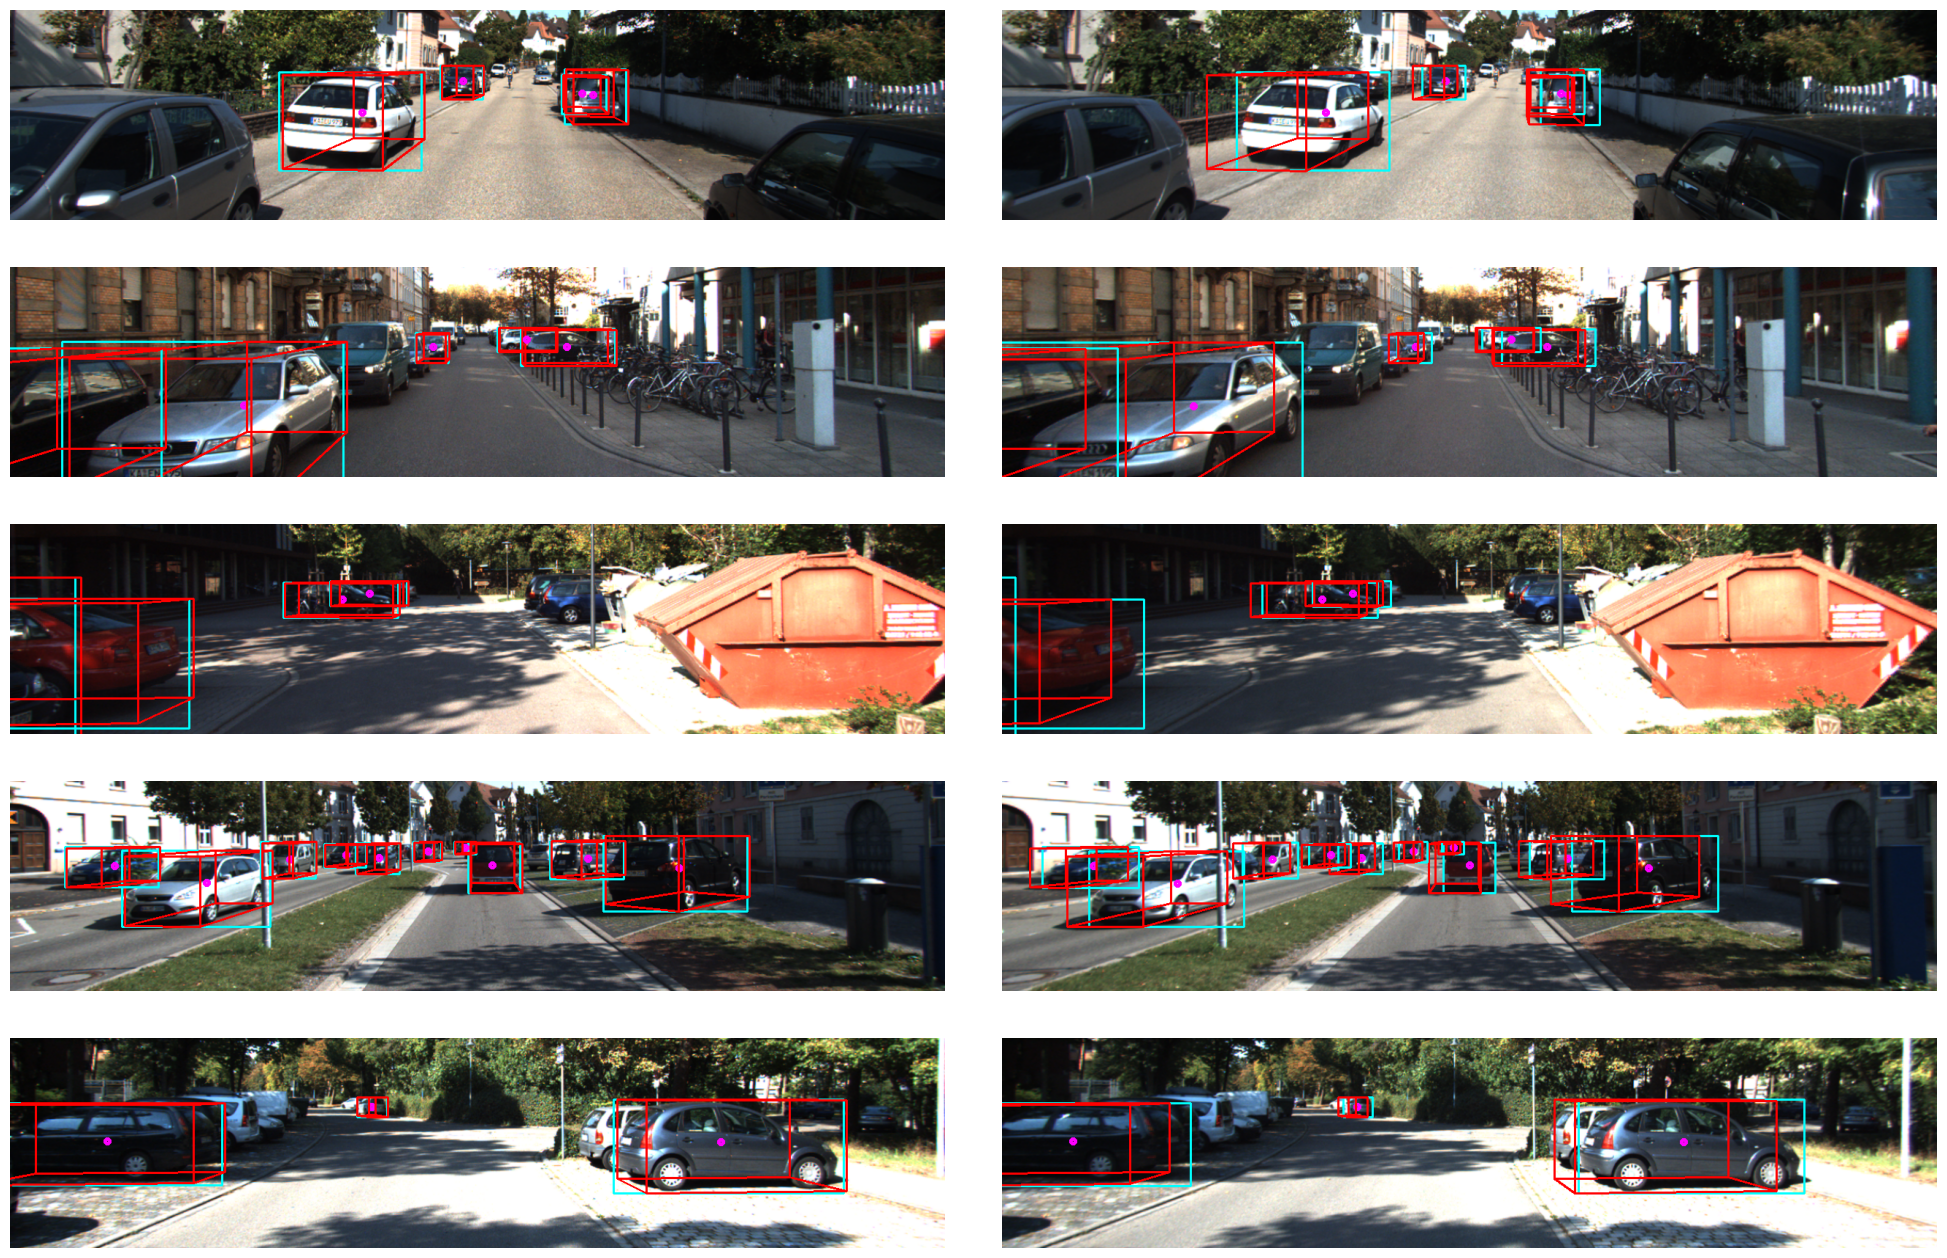

In [57]:
from visualDet3D.utils.utils import cfg_from_file

cfg = cfg_from_file("config/viz_da.py")
dataset_train = KittiMonoDataset(cfg)
dataloader_train = DataLoader(dataset_train, num_workers=cfg.data.num_workers,
                                batch_size=cfg.data.batch_size, collate_fn=dataset_train.collate_fn, shuffle=None, drop_last=True,
                                sampler=None)

images_out = []
for iter_num, data in enumerate(dataloader_train):
    # print(iter_num) # Double the size of training set? 
    # print(f"data[0] = {data[0].shape}") # IMage 
    image = data[0][0]
    # print(f"data[1] = {data[1].shape}") # calib
    # print(f"data[2] = {data[2]}") # Name of class
    # print(f"data[3] = {data[3]}") # 2D bbox's label  
    # print(f"data[4] = {}") # 3D boox's label
    P2 = data[1][0].numpy()
    image = image.permute(1,2,0).to(torch.int).numpy()
    for obj_idx in range(len(data[2][0])):
        # 2D Bounding Box
        x1, y1, x2, y2 = [int(i) for i in data[3][0][obj_idx]]
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 255), 2)

        # 3D Bounding Box
        cx, cy, cz, w, h, l, alpha  = data[4][0][obj_idx]
        obj_3d = Obj_3d(cx, cy, cz, w, h, l, alpha)

        corners = compute_3Dbox(P2, obj_3d)
        
        cv2.circle(image, (int(cx), int(cy)), 3, (255, 0, 255), 3)

        # Draw 3D box
        for idx in [(0, 1), (1, 2), (2, 7), (7, 0), 
                    (3, 6), (3, 4), (4, 5), (5, 6),
                    (0, 5), (1, 4), (2, 3), (6, 7)]:
            x1, y1 = int(corners[0][idx[0]]), int(corners[1][idx[0]])
            x2, y2 = int(corners[0][idx[1]]), int(corners[1][idx[1]])
            cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 2) 
    
    print(P2)
    images_out.append(image)

fig, ax = plt.subplots(5, 2, figsize=(20, 13))
fig.tight_layout()
fig.set_facecolor('white')
[b.axis('off') for a in ax for b in a ] # Delete all axis
# plotting the points
for i in range(10):
    ax[i%5, int(i/5)].imshow(images_out[i])

